In [332]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import datetime
from sqlalchemy import create_engine
from dateutil.parser import parse
import dateutil.parser
%matplotlib inline

In [3]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" 
    dfs = []
    for week_num in week_nums: 
        file_url = url.format(week_num) 
        dfs.append(pd.read_csv(file_url)) 
    return pd.concat(dfs) 
        

In [4]:
'''week_nums = [190105,
190202,
190302,
190406,
190504,
190601,
190706,
190803,
190907,
191005,
191102,
191207,
200104,
200201,
200307,
200404,
200502,
200606,
200704,
200801,
200905,
201003,
201107,
201205]
mta_project_df = get_data(week_nums)'''

'week_nums = [190105,\n190202,\n190302,\n190406,\n190504,\n190601,\n190706,\n190803,\n190907,\n191005,\n191102,\n191207,\n200104,\n200201,\n200307,\n200404,\n200502,\n200606,\n200704,\n200801,\n200905,\n201003,\n201107,\n201205]\nmta_project_df = get_data(week_nums)'

In [6]:
'''week_nums = [190112,
190202,
190302,
190406,
190504,
190601,
190706,
190803,
190907,
191005,
191102,
191207]

week_nums2 = [200111,
200201,
200307,
200404,
200502,
200606,
200704,
200801,
200905,
201003,
201107,
201205]'''

#week_nums3 = ['191005', '191012', '191019','191026']
#mta_project_df = get_data(week_nums3)

In [122]:
#week_nums_oct2020 = ['201010','201017','201024','201031']
#mta_project_df = get_data(week_nums_oct2020)

In [123]:
#mta_project_df.to_csv('october_2020.csv',header=False,index=False)
#mta_project_df.to_csv('october_2019.csv', header=False, index=False)
#mta_project_df.to_csv('mta_project_data_2019.csv', header=False, index=False)
#mta_project_df2.to_csv('mta_project_data_2020.csv', header=False, index=False)

In [333]:
engine = create_engine("sqlite:///mta_project.db")

In [334]:
year2019 = pd.read_sql('SELECT * FROM mta_data;', engine)

In [335]:
year2020 = pd.read_sql('SELECT * FROM mta_data2;', engine)

In [32]:
test=pd.read_sql('SELECT DATE,TIME from mta_oct;',engine)

In [336]:
def cleandf(df):
    #df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME,format="%m/%d/%Y %H:%M:%S")
    df['DATE_TIME']=pd.to_datetime(df['DATE'] + " " + df['TIME'])
    df['DAY_OF_WK'] = df['DATE_TIME'].dt.dayofweek
    df['WK_OF_YR'] = df['DATE_TIME'].dt.week
    df.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"],inplace=True, ascending=False)
    df.drop_duplicates(subset=["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)
    return df['DATE_TIME'], df['DAY_OF_WK']

In [337]:
year2020['DATE_TIME'],year2020['DAY_OF_WK']=cleandf(year2020)

<ipython-input-336-7fd5a7da0b76>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['WK_OF_YR'] = df['DATE_TIME'].dt.week


In [338]:
year2019['DATE_TIME'],year2019['DAY_OF_WK']=cleandf(year2019)

<ipython-input-336-7fd5a7da0b76>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['WK_OF_YR'] = df['DATE_TIME'].dt.week


In [339]:
turnstiles_daily = (year2020
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE","DAY_OF_WK","WK_OF_YR", "DATE_TIME",'TIME'],as_index=False).ENTRIES.first())

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)



<ipython-input-339-9d75fed73c64>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [340]:
turnstiles_daily.head()

,CA,UNIT,SCP,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 07:00:00,07:00:00,7331224,01/04/2020,7331213.0
2,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 11:00:00,11:00:00,7331281,01/04/2020,7331224.0
3,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 15:00:00,15:00:00,7331454,01/04/2020,7331281.0
4,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 19:00:00,19:00:00,7331759,01/04/2020,7331454.0
5,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 23:00:00,23:00:00,7331951,01/04/2020,7331759.0


In [341]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:

        counter = -counter
    if counter > max_counter:

        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:

        return 0
    return counter
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [342]:
'''def get_exit_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:

        counter = -counter
    if counter > max_counter:

        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:

        return 0
    return counter'''

'def get_exit_counts(row, max_counter):\n    counter = row["EXITS"] - row["PREV_EXITS"]\n    if counter < 0:\n\n        counter = -counter\n    if counter > max_counter:\n\n        counter = min(row["EXITS"], row["PREV_EXITS"])\n    if counter > max_counter:\n\n        return 0\n    return counter'

In [343]:
turnstiles_daily.head()

,CA,UNIT,SCP,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 07:00:00,07:00:00,7331224,01/04/2020,7331213.0,11.0
2,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 11:00:00,11:00:00,7331281,01/04/2020,7331224.0,57.0
3,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 15:00:00,15:00:00,7331454,01/04/2020,7331281.0,173.0
4,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 19:00:00,19:00:00,7331759,01/04/2020,7331454.0,305.0
5,A002,R051,02-00-00,59 ST,01/04/2020,5,1,2020-01-04 23:00:00,23:00:00,7331951,01/04/2020,7331759.0,192.0


In [344]:
stations_daily=(turnstiles_daily.groupby(['STATION', 'DATE'])[['DAILY_ENTRIES']].sum().reset_index())
stations_daily

,STATION,DATE,DAILY_ENTRIES
0,1 AV,01/04/2020,6015.0
1,1 AV,01/05/2020,5586.0
2,1 AV,01/06/2020,16560.0
3,1 AV,01/07/2020,17060.0
4,1 AV,01/08/2020,17651.0
...,...,...,...
31767,ZEREGA AV,11/30/2020,958.0
31768,ZEREGA AV,12/01/2020,1080.0
31769,ZEREGA AV,12/02/2020,995.0
31770,ZEREGA AV,12/03/2020,1015.0


In [345]:
stations_daily_dow=(turnstiles_daily.groupby(['STATION', 'DATE','DAY_OF_WK','WK_OF_YR','DATE_TIME','TIME'])[['DAILY_ENTRIES']].sum().reset_index())

stations_daily_dow = stations_daily_dow[stations_daily_dow['DAY_OF_WK'].isin([0,1,2,3,4])]
stations_daily_dow

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES
11,1 AV,01/06/2020,0,2,2020-01-06 03:00:00,03:00:00,297.0
12,1 AV,01/06/2020,0,2,2020-01-06 07:00:00,07:00:00,417.0
13,1 AV,01/06/2020,0,2,2020-01-06 11:00:00,11:00:00,4821.0
14,1 AV,01/06/2020,0,2,2020-01-06 15:00:00,15:00:00,2875.0
15,1 AV,01/06/2020,0,2,2020-01-06 19:00:00,19:00:00,5873.0
...,...,...,...,...,...,...,...
362801,ZEREGA AV,12/04/2020,4,49,2020-12-04 04:00:00,04:00:00,6.0
362802,ZEREGA AV,12/04/2020,4,49,2020-12-04 08:00:00,08:00:00,357.0
362803,ZEREGA AV,12/04/2020,4,49,2020-12-04 12:00:00,12:00:00,217.0
362804,ZEREGA AV,12/04/2020,4,49,2020-12-04 16:00:00,16:00:00,163.0


In [346]:
stations_daily_dow['DAY_OF_WK'].value_counts()

0    52298
4    52005
3    51933
2    51867
1    51487
Name: DAY_OF_WK, dtype: int64

In [347]:
stn = stations_daily.groupby(['STATION']).sum().sort_values('DAILY_ENTRIES',ascending=False).reset_index()
stn.head(15)


,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,18749395.0
1,34 ST-HERALD SQ,18748367.0
2,GRD CNTRL-42 ST,13305109.0
3,23 ST,12932960.0
4,42 ST-PORT AUTH,11110419.0
5,86 ST,11054617.0
6,FULTON ST,10846170.0
7,14 ST-UNION SQ,9489194.0
8,125 ST,9358026.0
9,TIMES SQ-42 ST,9282837.0


In [348]:
station_42st = stations_daily[stations_daily['STATION'] == '42 ST-PORT AUTH']

In [349]:
station_42st['WK_OF_YR'] = pd.to_datetime(station_42st['DATE']).dt.week

<ipython-input-349-aebc5a2039e8>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  station_42st['WK_OF_YR'] = pd.to_datetime(station_42st['DATE']).dt.week
<ipython-input-349-aebc5a2039e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_42st['WK_OF_YR'] = pd.to_datetime(station_42st['DATE']).dt.week


In [350]:
station_42st

,STATION,DATE,DAILY_ENTRIES,WK_OF_YR
5712,42 ST-PORT AUTH,01/04/2020,50110.0,1
5713,42 ST-PORT AUTH,01/05/2020,51016.0,1
5714,42 ST-PORT AUTH,01/06/2020,96724.0,2
5715,42 ST-PORT AUTH,01/07/2020,96682.0,2
5716,42 ST-PORT AUTH,01/08/2020,101120.0,2
...,...,...,...,...
5791,42 ST-PORT AUTH,11/30/2020,21832.0,49
5792,42 ST-PORT AUTH,12/01/2020,23295.0,49
5793,42 ST-PORT AUTH,12/02/2020,23562.0,49
5794,42 ST-PORT AUTH,12/03/2020,23519.0,49


In [351]:
dow_counts = stations_daily_dow.groupby(['DAY_OF_WK'])['DAILY_ENTRIES'].mean().reset_index()

In [352]:
dow_counts

,DAY_OF_WK,DAILY_ENTRIES
0,0,656.266664
1,1,702.925224
2,2,800.206432
3,3,659.558566
4,4,638.381790


In [353]:
stations_daily_dow

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES
11,1 AV,01/06/2020,0,2,2020-01-06 03:00:00,03:00:00,297.0
12,1 AV,01/06/2020,0,2,2020-01-06 07:00:00,07:00:00,417.0
13,1 AV,01/06/2020,0,2,2020-01-06 11:00:00,11:00:00,4821.0
14,1 AV,01/06/2020,0,2,2020-01-06 15:00:00,15:00:00,2875.0
15,1 AV,01/06/2020,0,2,2020-01-06 19:00:00,19:00:00,5873.0
...,...,...,...,...,...,...,...
362801,ZEREGA AV,12/04/2020,4,49,2020-12-04 04:00:00,04:00:00,6.0
362802,ZEREGA AV,12/04/2020,4,49,2020-12-04 08:00:00,08:00:00,357.0
362803,ZEREGA AV,12/04/2020,4,49,2020-12-04 12:00:00,12:00:00,217.0
362804,ZEREGA AV,12/04/2020,4,49,2020-12-04 16:00:00,16:00:00,163.0


In [354]:
'''top_wk = stations_daily_dow.loc[(stations_daily_dow['STATION']=='34 ST-PENN STA')|
                                (stations_daily_dow['STATION']=='GRD CNTRL-42 ST')|
                                (stations_daily_dow['STATION']=='23 ST')|
                                (stations_daily_dow['STATION']=='34 ST-HERALD SQ')|
                                (stations_daily_dow['STATION']=='TIMES SQ-42 ST')|
                                (stations_daily_dow['STATION']=='42 ST-PORT AUTH')|
                                (stations_daily_dow['STATION']=='14 ST-UNION SQ')|
                                (stations_daily_dow['STATION']=='FULTON ST')|
                                (stations_daily_dow['STATION']=='86 ST')|
                                (stations_daily_dow['STATION']=='CANAL ST')]'''

top_wk = stations_daily_dow.loc[(stations_daily_dow['STATION']=='34 ST-PENN STA')|
                                (stations_daily_dow['STATION']=='34 ST-HERALD SQ')|
                                (stations_daily_dow['STATION']=='GRD CNTRL-42 ST')|
                                (stations_daily_dow['STATION']=='23 ST')|
                                (stations_daily_dow['STATION']=='42 ST-PORT AUTH')|
                                (stations_daily_dow['STATION']=='86 ST')|
                                (stations_daily_dow['STATION']=='FULTON ST')|
                                (stations_daily_dow['STATION']=='14 ST-UNION SQ')|
                                (stations_daily_dow['STATION']=='TIMES SQ-42 ST')|
                                (stations_daily_dow['STATION']=='CANAL ST')]
top_wk['DATE']=pd.to_datetime(top_wk['DATE'])

top_wk = top_wk[top_wk['DAY_OF_WK'].isin([0,1,2,3,4])]
top_wk = top_wk.drop(index = 39706)
top_wk = top_wk.drop(index = 39707)
top_wk = top_wk.drop(index = 157602)
top_wk = top_wk.drop(index = 32768) 
top_wk = top_wk[top_wk['DAY_OF_WK'].isin([0,1,2,3,4])]
top_wk.sort_values('DAILY_ENTRIES',ascending=False)

<ipython-input-354-23eb210630af>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_wk['DATE']=pd.to_datetime(top_wk['DATE'])


,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES
68587,86 ST,2020-03-02,0,10,2020-03-02 23:00:00,23:00:00,1151742.0
40806,34 ST-PENN STA,2020-03-02,0,10,2020-03-02 17:00:00,17:00:00,698925.0
32261,23 ST,2020-03-06,4,10,2020-03-06 00:00:00,00:00:00,596655.0
68418,86 ST,2020-01-09,3,2,2020-01-09 11:00:00,11:00:00,444760.0
161743,GRD CNTRL-42 ST,2020-07-29,2,31,2020-07-29 16:00:00,16:00:00,286856.0
...,...,...,...,...,...,...,...
45730,42 ST-PORT AUTH,2020-12-03,3,49,2020-12-03 11:34:14,11:34:14,0.0
157570,FULTON ST,2020-08-31,0,36,2020-08-31 10:04:26,10:04:26,0.0
157578,FULTON ST,2020-08-31,0,36,2020-08-31 11:36:19,11:36:19,0.0
105741,CANAL ST,2020-11-03,1,45,2020-11-03 03:00:00,03:00:00,0.0


In [355]:
top_wk

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES
9084,14 ST-UNION SQ,2020-01-06,0,2,2020-01-06 00:00:00,00:00:00,7591.0
9085,14 ST-UNION SQ,2020-01-06,0,2,2020-01-06 04:00:00,04:00:00,900.0
9086,14 ST-UNION SQ,2020-01-06,0,2,2020-01-06 08:00:00,08:00:00,3418.0
9087,14 ST-UNION SQ,2020-01-06,0,2,2020-01-06 12:00:00,12:00:00,13201.0
9088,14 ST-UNION SQ,2020-01-06,0,2,2020-01-06 16:00:00,16:00:00,19649.0
...,...,...,...,...,...,...,...
344972,TIMES SQ-42 ST,2020-12-04,4,49,2020-12-04 11:48:39,11:48:39,1.0
344973,TIMES SQ-42 ST,2020-12-04,4,49,2020-12-04 11:50:00,11:50:00,5.0
344974,TIMES SQ-42 ST,2020-12-04,4,49,2020-12-04 15:00:00,15:00:00,3282.0
344975,TIMES SQ-42 ST,2020-12-04,4,49,2020-12-04 19:00:00,19:00:00,6372.0


In [356]:
totals = top_wk.groupby(by='STATION',as_index=False).sum()[['STATION','DAILY_ENTRIES']].sort_values('DAILY_ENTRIES',ascending=False)
totals

,STATION,DAILY_ENTRIES
3,34 ST-PENN STA,4099404.0
5,86 ST,3651991.0
8,GRD CNTRL-42 ST,3179073.0
1,23 ST,3085858.0
2,34 ST-HERALD SQ,2531884.0
4,42 ST-PORT AUTH,2207273.0
0,14 ST-UNION SQ,2108125.0
7,FULTON ST,2043283.0
9,TIMES SQ-42 ST,1975609.0
6,CANAL ST,1674607.0


In [357]:
top_wk['TIMEP']=top_wk['TIME'].apply(parse)

In [358]:
'''
stations10 = top_wk[top_wk['STATION'].isin(['34 ST-PENN STA',
                   'GRD CNTRL-42 ST',
                   '23 ST',
                   '34 ST-HERALD SQ',
                   'TIMES SQ-42 ST',
                   '42 ST-PORT AUTH',
                   '14 ST-UNION SQ',
                   'FULTON ST',
                   '86 ST',
                   'CANAL ST'])]

stations10 = stations10.groupby(by=['STATION', 'TIMEP'], as_index=False).sum()[['STATION', 'TIMEP','DAILY_ENTRIES']]
stations10.set_index('TIMEP', drop=True, inplace=True)
stations10 = stations10.groupby(by=['STATION']).resample('4H').mean()
stations10 = stations10.reset_index()'''


stations10 = top_wk[top_wk['STATION'].isin(['34 ST-PENN STA',
                   '34 ST-HERALD SQ',
                   'GRD CNTRL-42 ST',
                   '23 ST',
                   '42 ST-PORT AUTH',
                   '86 ST',
                   'FULTON ST',
                   '14 ST-UNION SQ',
                   'TIMES SQ-42 ST',
                   'CANAL ST'])]

stations10 = stations10.groupby(by=['STATION', 'TIMEP'], as_index=False).sum()[['STATION', 'TIMEP','DAILY_ENTRIES']]
stations10.set_index('TIMEP', drop=True, inplace=True)
stations10 = stations10.groupby(by=['STATION']).resample('4H').mean()
stations10 = stations10.reset_index()

In [359]:
stations10.head()

,STATION,TIMEP,DAILY_ENTRIES
0,14 ST-UNION SQ,2021-04-30 00:00:00,141656.0
1,14 ST-UNION SQ,2021-04-30 04:00:00,12323.5
2,14 ST-UNION SQ,2021-04-30 08:00:00,33092.0
3,14 ST-UNION SQ,2021-04-30 12:00:00,157347.5
4,14 ST-UNION SQ,2021-04-30 16:00:00,284178.0


In [360]:
stations_wk = top_wk[top_wk['STATION'].isin(['34 ST-PENN STA',
                   '34 ST-HERALD SQ',
                   'GRD CNTRL-42 ST',
                   '23 ST',
                   '42 ST-PORT AUTH',
                   '86 ST',
                   'FULTON ST',
                   '14 ST-UNION SQ',
                   'TIMES SQ-42 ST',
                   'CANAL ST'])]
stations_wk = stations_wk.groupby(by=['STATION', 'DAY_OF_WK'], as_index=False).sum()[['STATION', 'DAY_OF_WK','DAILY_ENTRIES']]
stations_wk.head()

,STATION,DAY_OF_WK,DAILY_ENTRIES
0,14 ST-UNION SQ,0,385935.0
1,14 ST-UNION SQ,1,420956.0
2,14 ST-UNION SQ,2,434330.0
3,14 ST-UNION SQ,3,433474.0
4,14 ST-UNION SQ,4,433430.0


In [361]:
stations_wk.loc[stations_wk['DAY_OF_WK'] == '0', 'day'] = 'Monday'
stations_wk.loc[stations_wk['DAY_OF_WK'] == '1', 'day'] = 'Tuesday'
stations_wk.loc[stations_wk['DAY_OF_WK'] == '2', 'day'] = 'Wednesday'
stations_wk.loc[stations_wk['DAY_OF_WK'] == '3', 'day'] = 'Thursday'
stations_wk.loc[stations_wk['DAY_OF_WK'] == '4', 'day'] = 'Friday'

/Users/ju/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Traffic Per Weekday (2020)')

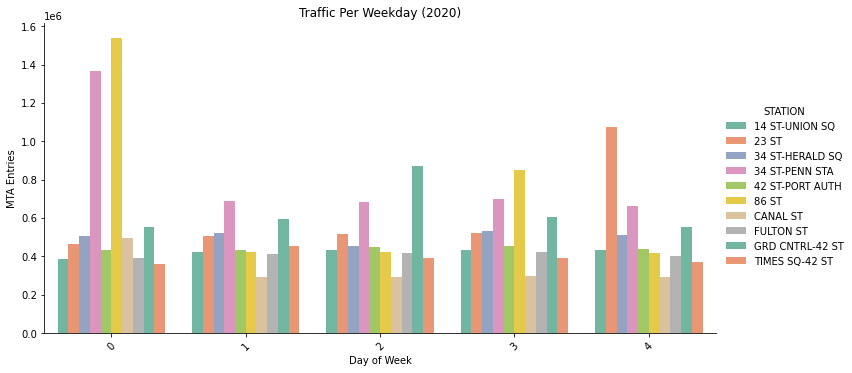

In [362]:
bchart = sns.catplot('DAY_OF_WK', 'DAILY_ENTRIES', hue ='STATION', kind = 'bar', data = stations_wk, aspect = 2, palette=sns.color_palette("Set2"))

'''labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
ax.set_yticklabels(labels)
ax.set_xlabel('Day of Week')
ax.set_ylabel('MTA Entries')'''
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('MTA Entries')
plt.title('Traffic Per Weekday (2020)')



In [363]:
test = top_wk[top_wk['STATION'].isin(['23 ST'])]
test.sort_values('DAILY_ENTRIES',ascending=False)
#significant outliers on march 4th 2020...will remove

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES,TIMEP
32261,23 ST,2020-03-06,4,10,2020-03-06 00:00:00,00:00:00,596655.0,2021-04-30 00:00:00
32162,23 ST,2020-01-29,2,5,2020-01-29 19:00:00,19:00:00,34948.0,2021-04-30 19:00:00
32150,23 ST,2020-01-28,1,5,2020-01-28 19:00:00,19:00:00,34797.0,2021-04-30 19:00:00
32078,23 ST,2020-01-08,2,2,2020-01-08 19:00:00,19:00:00,34557.0,2021-04-30 19:00:00
32066,23 ST,2020-01-07,1,2,2020-01-07 19:00:00,19:00:00,34355.0,2021-04-30 19:00:00
...,...,...,...,...,...,...,...,...
32591,23 ST,2020-07-02,3,27,2020-07-02 05:00:00,05:00:00,1.0,2021-04-30 05:00:00
32639,23 ST,2020-07-27,0,31,2020-07-27 05:00:00,05:00:00,1.0,2021-04-30 05:00:00
32555,23 ST,2020-06-29,0,27,2020-06-29 07:34:52,07:34:52,1.0,2021-04-30 07:34:52
32579,23 ST,2020-07-01,2,27,2020-07-01 05:00:00,05:00:00,0.0,2021-04-30 05:00:00


In [364]:
march = top_wk[top_wk['DATE']=='2020-03-02']
march.sort_values('DAILY_ENTRIES',ascending=False)

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES,TIMEP
68587,86 ST,2020-03-02,0,10,2020-03-02 23:00:00,23:00:00,1151742.0,2021-04-30 23:00:00
40806,34 ST-PENN STA,2020-03-02,0,10,2020-03-02 17:00:00,17:00:00,698925.0,2021-04-30 17:00:00
39694,34 ST-HERALD SQ,2020-03-02,0,10,2020-03-02 19:00:00,19:00:00,46056.0,2021-04-30 19:00:00
40802,34 ST-PENN STA,2020-03-02,0,10,2020-03-02 11:00:00,11:00:00,40202.0,2021-04-30 11:00:00
161301,GRD CNTRL-42 ST,2020-03-02,0,10,2020-03-02 20:00:00,20:00:00,39328.0,2021-04-30 20:00:00
...,...,...,...,...,...,...,...,...
68574,86 ST,2020-03-02,0,10,2020-03-02 18:28:03,18:28:03,14.0,2021-04-30 18:28:03
68560,86 ST,2020-03-02,0,10,2020-03-02 18:10:03,18:10:03,13.0,2021-04-30 18:10:03
68584,86 ST,2020-03-02,0,10,2020-03-02 18:41:26,18:41:26,11.0,2021-04-30 18:41:26
68564,86 ST,2020-03-02,0,10,2020-03-02 18:14:29,18:14:29,9.0,2021-04-30 18:14:29


/Users/ju/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Entries by Weekdays')

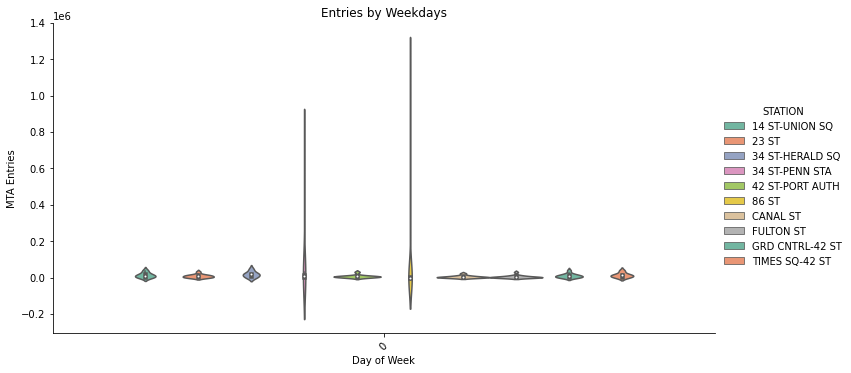

In [365]:
chart = sns.catplot('DAY_OF_WK', 'DAILY_ENTRIES', hue ='STATION', kind = 'violin', data = march, aspect = 2, palette=sns.color_palette("Set2"))

'''labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
ax.set_yticklabels(labels)
ax.set_xlabel('Day of Week')
ax.set_ylabel('MTA Entries')'''
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('MTA Entries')
plt.title('Entries by Weekdays')


In [366]:
#top_wk = top_wk.drop(['DAILY ENTRIES']==3410827.0)
#top_wk.sort_values('DAILY_ENTRIES',ascending=False)

In [367]:
'''top_wk = top_wk.drop(index = 39706)
top_wk.sort_values('DAILY_ENTRIES',ascending=False)'''

"top_wk = top_wk.drop(index = 39706)\ntop_wk.sort_values('DAILY_ENTRIES',ascending=False)"

In [368]:
stations10.loc[stations10['TIMEP'] == '00:00:00', 'dt'] = '8:00 PM - Midnight'
stations10.loc[stations10['TIMEP'] == '04:00:00', 'dt'] = 'Midnight - 4:00 AM'
stations10.loc[stations10['TIMEP'] == '08:00:00', 'dt'] = '4:00 AM - 8:00 AM'
stations10.loc[stations10['TIMEP'] == '12:00:00', 'dt'] = '8:00 AM - Noon'
stations10.loc[stations10['TIMEP'] == '16:00:00', 'dt'] = 'Noon - 4:00 PM'
stations10.loc[stations10['TIMEP'] == '20:00:00', 'dt'] = '4:00 PM - 8:00 PM'

/Users/ju/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


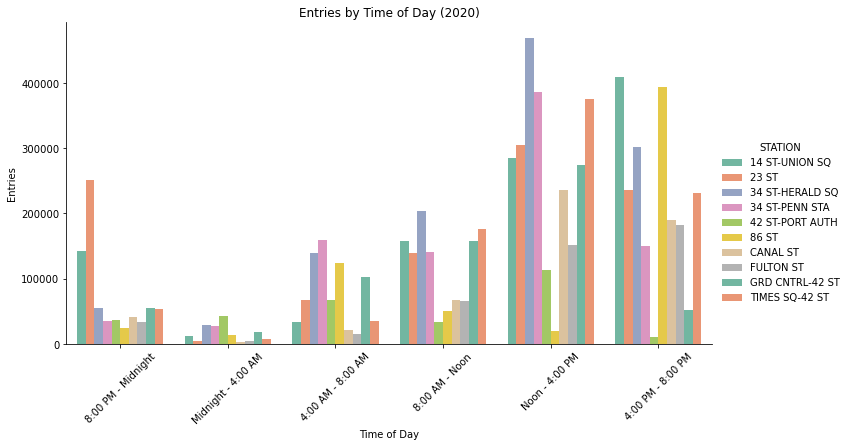

In [369]:
chart_times = sns.catplot('dt', 'DAILY_ENTRIES', hue ='STATION', kind = 'bar', data = stations10, aspect = 2, palette=sns.color_palette("Set2"))
plt.xticks(rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Entries')
plt.title("Entries by Time of Day (2020)")

plt.savefig('2020_traffic_by_time_of_day.png')


<BarContainer object of 50 artists>

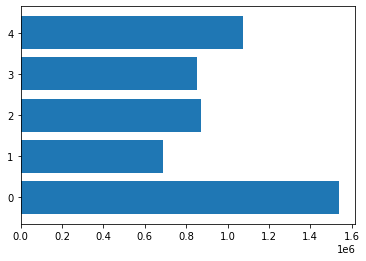

In [370]:

x = stations_wk['DAY_OF_WK']
y = stations_wk['DAILY_ENTRIES']

plt.barh(x,y)

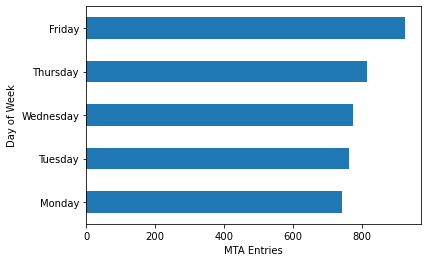

In [371]:
plotframe=stations_daily_dow[stations_daily_dow['DAILY_ENTRIES']!=0]
ax = plotframe.groupby('DAY_OF_WK').DAILY_ENTRIES.mean().sort_values().plot(kind='barh')
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'

ax.set_yticklabels(labels)
ax.set_ylabel('Day of Week')
ax.set_xlabel('MTA Entries')

plt.show()



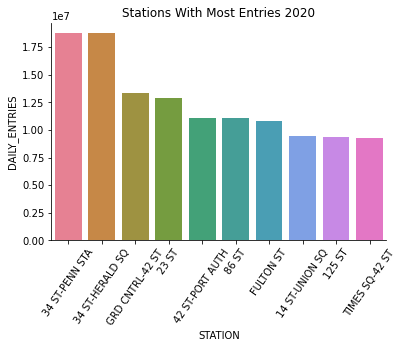

In [373]:
chart = sns.barplot(x ='STATION',y='DAILY_ENTRIES',data=stn[:10],palette = sns.color_palette("husl", 10));
chart.set_xticklabels(chart.get_xticklabels(), rotation=55)
chart.set_title('Stations With Most Entries 2020')
sns.despine()

plt.savefig('2020_daily_entries.jpg')